In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso

In [1]:
df = pd.DataFrame(np.random.randint(10, size=(10, 5)), columns=list('abcde'))
print (df)

NameError: name 'pd' is not defined

In [4]:
df_1 = df.rolling(5).mean()
print (df_1)

     a    b    c    d    e
0  NaN  NaN  NaN  NaN  NaN
1  NaN  NaN  NaN  NaN  NaN
2  NaN  NaN  NaN  NaN  NaN
3  NaN  NaN  NaN  NaN  NaN
4  3.8  5.8  4.8  2.2  4.6
5  4.0  6.4  5.0  1.0  4.8
6  3.8  6.2  4.4  2.2  5.6
7  3.6  5.6  6.0  3.2  4.4
8  4.6  4.0  7.0  4.6  2.8
9  4.4  3.6  6.0  5.0  3.4


In [5]:
df_2 = df.rolling(5, min_periods=3).mean()
print (df_2)

     a    b         c     d     e
0  NaN  NaN       NaN   NaN   NaN
1  NaN  NaN       NaN   NaN   NaN
2  5.0  5.0  4.333333  3.00  5.00
3  4.5  6.0  3.750000  2.75  5.75
4  3.8  5.8  4.800000  2.20  4.60
5  4.0  6.4  5.000000  1.00  4.80
6  3.8  6.2  4.400000  2.20  5.60
7  3.6  5.6  6.000000  3.20  4.40
8  4.6  4.0  7.000000  4.60  2.80
9  4.4  3.6  6.000000  5.00  3.40


In [2]:
train = pd.read_csv('data/train.csv')

In [4]:
test = pd.read_csv('data/test.csv')

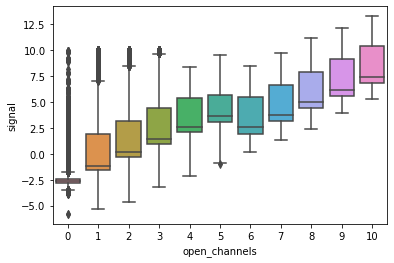

In [8]:
ax = sns.boxplot(x="open_channels", y="signal", data=train)

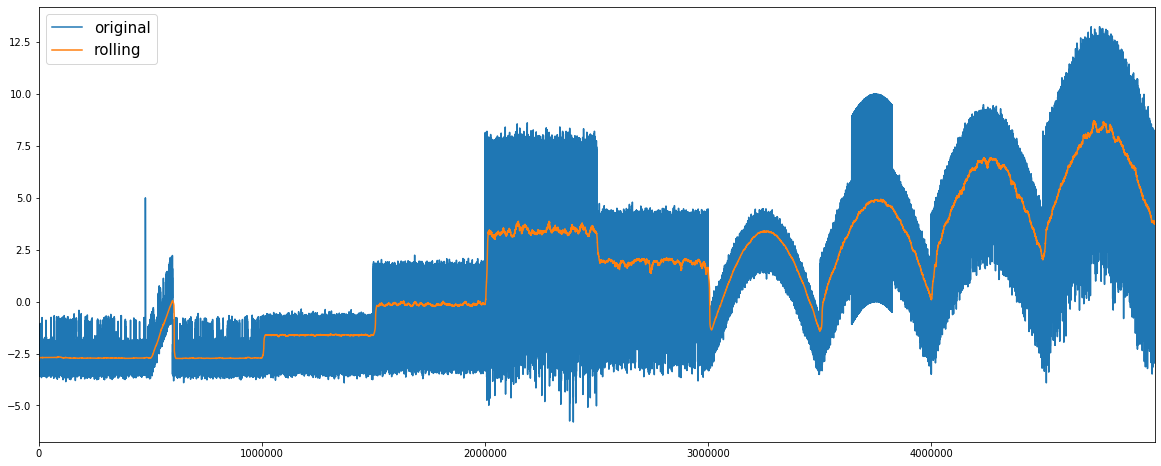

In [9]:
# train.signal.plot(style='k.-')
plt.figure(figsize=(20, 8))
plt.plot(train.signal, label='original')
train.rolling(15000, min_periods=1).signal.median().plot(label='rolling')
plt.legend(loc="upper left",fontsize=15)
plt.show()

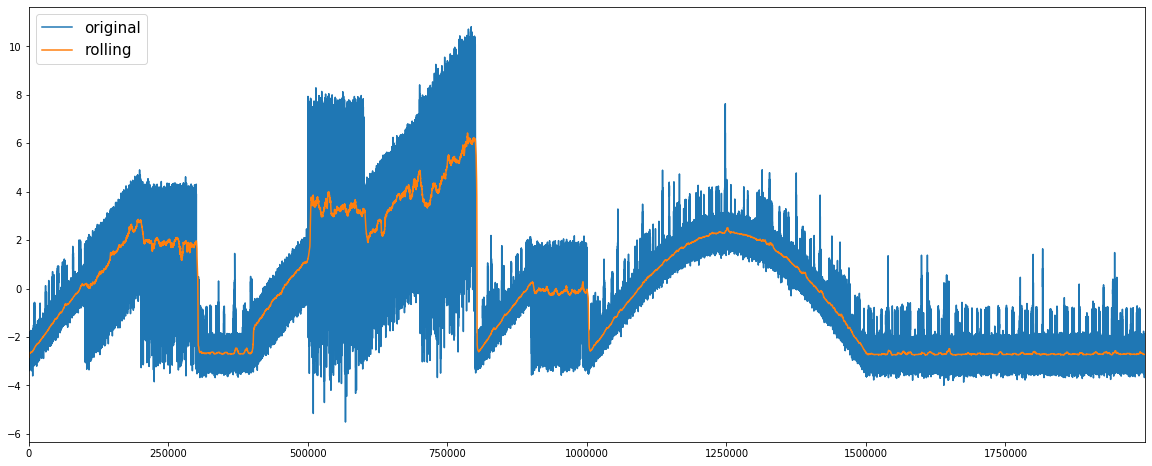

In [52]:
# train.signal.plot(style='k.-')
plt.figure(figsize=(20, 8))
plt.plot(test.signal, label='original')
test.rolling(6000, min_periods=1).signal.median().plot(label='rolling')
plt.legend(loc="upper left",fontsize=15)
plt.show()

In [4]:
base_stats = train.signal.rolling(15000, min_periods=1).agg(['median', 'mean', 'std', 'max', 'min'])

In [5]:
base_stats['skew'] = base_stats['mean'] - base_stats['median']

In [6]:
base_stats['skewness'] = 3 * base_stats['skew'] / base_stats['std'] 

In [5]:
def right_left_skew(x):
    if x > 0:
        x = 1 
    elif x < 0:
        x = -1
    else:
        x = 0
    return x

In [8]:
base_stats['skew'] = base_stats['skew'].apply(right_left_skew)

In [9]:
base_stats['coefficient_variation'] = base_stats['std'] / base_stats['median']

In [10]:
base_stats['range'] = base_stats['max'] - base_stats['min']

In [11]:
base_stats['max_min_ratio'] =  base_stats['max'] / base_stats['min']

In [12]:
train = pd.concat([train[['signal','open_channels']], base_stats], axis=1)

In [13]:
train['shift'] = train.signal.shift()

In [14]:
train['lagged'] =  train.signal.shift(periods=-1)

In [15]:
train['signal_diff'] = train.signal.diff()

In [16]:
train['signal_change'] = train.signal.pct_change()

In [17]:
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

In [18]:
train['rolling_return'] = train.signal_change.rolling(15000, min_periods=1).apply(multi_period_return)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


In [6]:
stats = test.signal.rolling(6000, min_periods=1).agg(['median', 'mean', 'std', 'max', 'min'])

In [7]:
stats['skew'] = stats['mean'] - stats['median']

In [8]:
stats['skewness'] = 3 * stats['skew'] / stats['std'] 

In [9]:
stats['skew'] = stats['skew'].apply(right_left_skew)

In [10]:
stats['coefficient_variation'] = stats['std'] / stats['median']

In [11]:
stats['range'] = stats['max'] - stats['min']

In [12]:
stats['max_min_ratio'] =  stats['max'] / stats['min']

In [13]:
test = pd.concat([test['signal'], stats], axis=1)

In [14]:
test['shift'] = test.signal.shift()
test['lagged'] =  test.signal.shift(periods=-1)
test['signal_diff'] = test.signal.diff()
test['signal_change'] = test.signal.pct_change()

In [62]:
test['rolling_return'] = test.signal_change.rolling(6000, min_periods=1).apply(multi_period_return)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


In [26]:
train_predictor = train.drop(['open_channels'], axis=1).fillna(0)

In [72]:
type(train_predictor)

pandas.core.frame.DataFrame

In [25]:
train_predictor.describe()

,signal,median,mean,std,max,min,skew,skewness,range,max_min_ratio,shift,lagged,signal_diff
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,1.386246e+00,1.450570e+00,1.376623e+00,1.025698e+00,4.138091e+00,-2.444943e+00,-2.549236e-01,-2.343826e-01,6.583034e+00,-3.636937e+00,1.386245e+00,1.386247e+00,1.627840e-06
std,3.336219e+00,3.159538e+00,3.131596e+00,5.328569e-01,4.195246e+00,1.792573e+00,9.669611e-01,4.696049e-01,3.577355e+00,1.158786e+02,3.336219e+00,3.336219e+00,9.176951e-01
min,-5.796500e+00,-2.857500e+00,-2.863200e+00,0.000000e+00,-2.760000e+00,-5.796500e+00,-1.000000e+00,-1.736820e+00,0.000000e+00,-7.939375e+03,-5.796500e+00,-5.796500e+00,-9.999900e+00
25%,-1.594800e+00,-1.604600e+00,-1.800750e+00,5.799090e-01,-4.880000e-01,-3.667500e+00,-1.000000e+00,-5.403252e-01,3.105800e+00,-1.865565e+00,-1.594800e+00,-1.594800e+00,-3.792000e-01
50%,1.124000e+00,1.813350e+00,1.616713e+00,1.020790e+00,4.193400e+00,-3.454300e+00,-1.000000e+00,-7.164996e-02,5.639200e+00,-5.546641e-01,1.124000e+00,1.124000e+00,-5.000000e-04
75%,3.690100e+00,3.500550e+00,3.452854e+00,1.312508e+00,8.069000e+00,-9.281000e-01,1.000000e+00,8.723843e-02,8.247500e+00,2.067161e-01,3.690025e+00,3.690100e+00,3.781000e-01
max,1.324400e+01,8.719600e+00,8.613524e+00,2.438953e+00,1.324400e+01,1.938000e+00,1.000000e+00,1.986941e+00,1.410030e+01,1.368901e+03,1.324400e+01,1.324400e+01,9.999900e+00


In [27]:
train_target = train['open_channels'].copy()

In [31]:
train_predictor.loc[train_predictor['signal_change'] == np.nan, 'signal_change']

Series([], Name: signal_change, dtype: float64)

In [28]:
train_predictor.loc[train_predictor['signal_change'] == -np.inf, 'signal_change'] = 0

In [29]:
train_predictor.loc[train_predictor['signal_change'] == np.inf, 'signal_change'] = 0

In [30]:
train_predictor.loc[train_predictor['coefficient_variation'] == np.inf, 'coefficient_variation'] = 0

In [31]:
train_predictor = train_predictor.astype('float32')

[ 0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


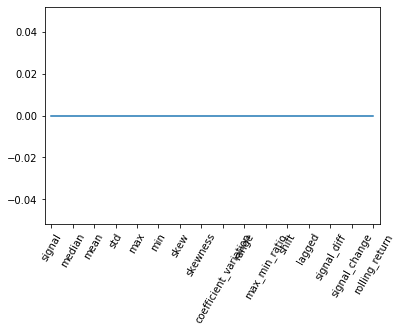

In [88]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha = 0.2, normalize = True)

# Fit the regressor to the data
lasso.fit(train_predictor,train_target)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
plt.plot(range(len(train_predictor.columns)), lasso_coef)
plt.xticks(range(len(train_predictor.columns)), train_predictor.columns.values, rotation=60)
plt.margins(0.02)
plt.show()

In [94]:
corrMatt = train.corr()

In [95]:
mask = np.array(corrMatt)

In [96]:
mask[np.triu_indices_from(mask)] = False

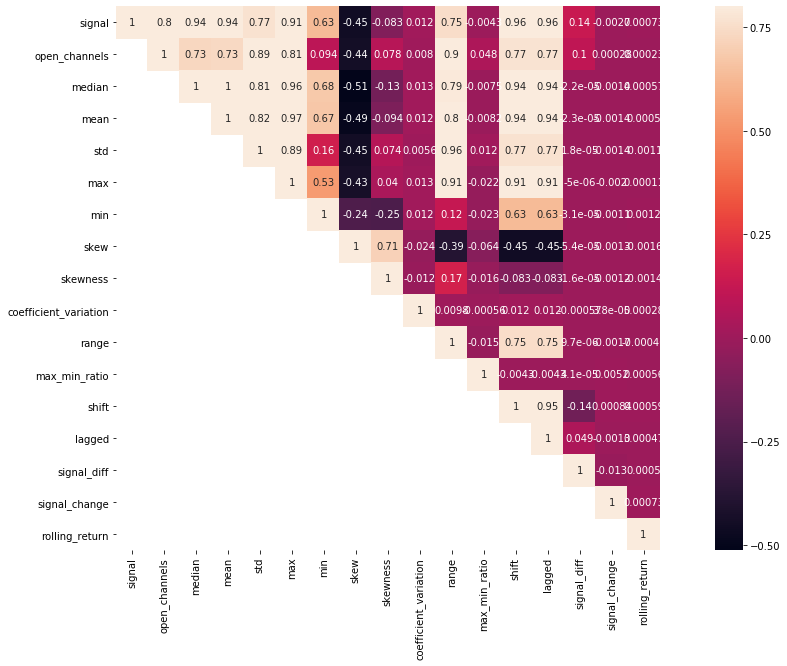

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

In [32]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_predictor, train_target, test_size=0.3, 
                                                    stratify=train_target, random_state = 321)

In [42]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
             'min_samples_split': [5, 10],
             'min_samples_leaf' : [5, 10],
             'n_estimators' : [50, 100]}

# Instantiate a Decision Tree classifier: tree
tree = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, n_jobs=-1, verbose=5, cv=3)

# Fit it to the data
tree_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 110.5min remaining: 40.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 135.2min finished


Tuned Decision Tree Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': None}
Best score is 0.9651525714285715


In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [46]:
accuracy_score(y_test, tree_cv.predict(X_test))

0.9657173333333333

In [30]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
test = test.fillna(0)

In [18]:
test.describe()

,signal,median,mean,std,max,min,skew,skewness,coefficient_variation,range,max_min_ratio,shift,lagged,signal_diff,signal_change
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,-4.259114e-02,-6.441047e-02,-4.250703e-02,7.218588e-01,2.229249e+00,-2.337447e+00,3.347620e-01,1.978676e-01,-9.643057e-01,4.566696e+00,-1.266413e+00,-4.258977e-02,-4.258981e-02,-4.620000e-08,4.466394e-02
std,2.505120e+00,2.397851e+00,2.341072e+00,5.230816e-01,3.099118e+00,1.578423e+00,9.423024e-01,5.154942e-01,7.120986e+01,2.969623e+00,1.762186e+01,2.505119e+00,2.505119e+00,6.808073e-01,4.039292e+01
min,-5.509600e+00,-2.849400e+00,-2.786400e+00,0.000000e+00,-2.649800e+00,-5.509600e+00,-1.000000e+00,-1.190588e+00,-1.092009e+04,0.000000e+00,-2.890374e+02,-5.509600e+00,-5.509600e+00,-1.069380e+01,-1.143750e+04
25%,-2.470600e+00,-2.649850e+00,-2.513328e+00,3.326858e-01,-6.006000e-01,-3.590100e+00,-1.000000e+00,-3.846182e-02,-2.052841e-01,2.784500e+00,-1.545320e+00,-2.470600e+00,-2.470600e+00,-2.907000e-01,-1.722921e-01
50%,-3.551000e-01,-1.950000e-01,-1.708926e-01,5.134982e-01,1.805100e+00,-3.036900e+00,1.000000e+00,1.424343e-01,-9.177698e-02,3.011100e+00,-3.118653e-01,-3.551000e-01,-3.551000e-01,-2.000000e-04,-1.406900e-02
75%,1.783400e+00,1.914750e+00,1.844734e+00,1.002940e+00,4.232900e+00,-1.329300e+00,1.000000e+00,5.815559e-01,4.182677e-01,5.391700e+00,2.269699e-01,1.783400e+00,1.783400e+00,2.904000e-01,1.466240e-01
max,1.081000e+01,6.422700e+00,6.309701e+00,4.520904e+00,1.081000e+01,1.537100e+00,1.000000e+00,2.485384e+00,2.013885e+04,1.393090e+01,2.750636e+02,1.081000e+01,1.081000e+01,6.835400e+00,1.791300e+04


In [17]:
test.loc[test['signal_change'] == np.inf, 'signal_change'] = 0
test.loc[test['coefficient_variation'] == np.inf, 'coefficient_variation'] = 0
test.loc[test['signal_change'] == -np.inf, 'signal_change'] = 0
test.loc[test['coefficient_variation'] == -np.inf, 'coefficient_variation'] = 0
test.loc[test['signal_change'] == np.nan, 'signal_change'] = 0
test.loc[test['coefficient_variation'] == np.nan, 'coefficient_variation'] = 0

In [31]:
y = rf_model.predict(X_test)

In [127]:
print(classification_report(y_test, y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    310405
           1       0.99      0.99      0.99    246083
           2       0.97      0.97      0.97    138445
           3       0.98      0.97      0.97    167782
           4       0.96      0.97      0.97    100869
           5       0.94      0.94      0.94     69552
           6       0.86      0.88      0.87     46853
           7       0.87      0.88      0.88     65987
           8       0.88      0.88      0.88     61018
           9       0.89      0.87      0.88     34234
          10       0.91      0.84      0.87      8772

    accuracy                           0.96   1250000
   macro avg       0.93      0.93      0.93   1250000
weighted avg       0.96      0.96      0.96   1250000



In [49]:
print(classification_report(y_test, tree_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    372046
           1       0.99      0.99      0.99    295759
           2       0.97      0.97      0.97    166177
           3       0.98      0.98      0.98    200583
           4       0.97      0.97      0.97    121023
           5       0.95      0.94      0.94     83363
           6       0.88      0.88      0.88     56434
           7       0.88      0.89      0.89     79504
           8       0.89      0.89      0.89     73555
           9       0.89      0.89      0.89     40836
          10       0.91      0.86      0.89     10720

    accuracy                           0.97   1500000
   macro avg       0.94      0.93      0.93   1500000
weighted avg       0.97      0.97      0.97   1500000



In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [37]:
y_pred = rf_model.predict(test)

In [67]:
y_pred = tree_cv.predict(test)

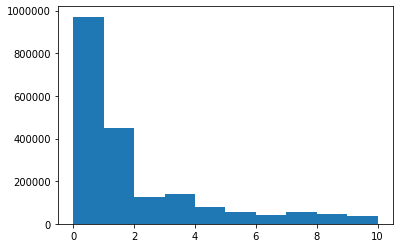

In [122]:
plt.hist(y_pred)
plt.show()

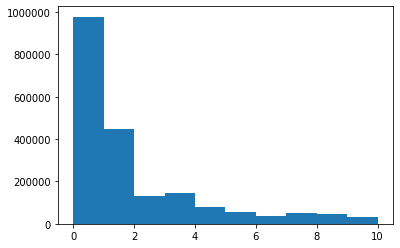

In [68]:
plt.hist(y_pred)
plt.show()

In [42]:
submission = pd.read_csv('data/sample_submission.csv')
submission['open_channels'] = y_pred
submission.to_csv('submission_6.csv', index=False, float_format='%.4f')
submission.open_channels

0          0
1          0
2          0
3          0
4          0
          ..
1999995    0
1999996    0
1999997    0
1999998    0
1999999    0
Name: open_channels, Length: 2000000, dtype: int64

In [124]:
submission.open_channels.value_counts()

0     971359
1     450958
3     140638
2     126287
4      77880
5      57101
7      53352
8      48294
6      39613
9      27200
10      7318
Name: open_channels, dtype: int64

In [40]:
y_pred = pd.Series(y_pred)

In [41]:
y_pred.value_counts()

0     992450
1     429535
3     140518
2     134842
4      78345
5      56606
7      51265
8      46374
6      37667
9      25620
10      6778
dtype: int64

In [1]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
from sklearn import metrics

In [36]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [101]:
cl = lgb.LGBMRegressor(n_jobs=-1)
cl.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [104]:
y_pred = cl.predict(test)

In [37]:
model = lgb.LGBMClassifier(n_estimators=3400, objective = 'multiclass', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

model.fit(X_train, y_train, eval_metric = 'multi_logloss',
          eval_set = [(X_test, y_test), (X_train, y_train)],
          eval_names = ['test', 'train'],
          early_stopping_rounds = 100, verbose = 200)

Training until validation scores don't improve for 100 rounds
[200]	train's multi_logloss: 0.181607	test's multi_logloss: 0.112975
[400]	train's multi_logloss: 0.162569	test's multi_logloss: 0.098917
[600]	train's multi_logloss: 0.154335	test's multi_logloss: 0.0951283
[800]	train's multi_logloss: 0.148638	test's multi_logloss: 0.0934708
[1000]	train's multi_logloss: 0.143873	test's multi_logloss: 0.0924481
[1200]	train's multi_logloss: 0.139759	test's multi_logloss: 0.0918403
[1400]	train's multi_logloss: 0.136082	test's multi_logloss: 0.0914113
[1600]	train's multi_logloss: 0.132663	test's multi_logloss: 0.091103
[1800]	train's multi_logloss: 0.129506	test's multi_logloss: 0.0908923
[2000]	train's multi_logloss: 0.126548	test's multi_logloss: 0.0907305
[2200]	train's multi_logloss: 0.123755	test's multi_logloss: 0.09062
[2400]	train's multi_logloss: 0.121116	test's multi_logloss: 0.0905112
[2600]	train's multi_logloss: 0.118625	test's multi_logloss: 0.0904601
[2800]	train's multi_log

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.05, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=3400,
               n_jobs=-1, num_leaves=31, objective='multiclass',
               random_state=50, reg_alpha=0.1, reg_lambda=0.1, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [38]:
model.booster_.save_model('mode.txt')

In [3]:
bst = lgb.Booster(model_file='mode.txt')

In [19]:
y_pred = bst.predict(test)

In [23]:
y_pred = np.argmax(y_pred, axis=1)

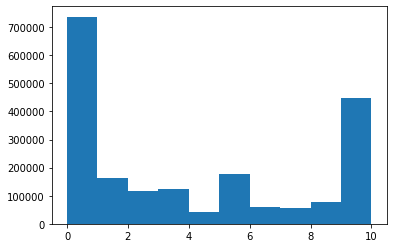

In [24]:
plt.hist(y_pred)
plt.show()